# Plot TimeLine Activity (automatic)

This codes allows to plot the activity (i.e. distance traveled per 10-min time bin) for each individual over the whole experiment. It saves the figure as a pdf file for each experiment. It also provides a txt file with the distance traveled in each time bin for each individual as well as the total distance traveled.

| ![](../images/timeline.jpg) | 
|:--:| 
|TimeLine example|


Code launched.
Enter time information in frame. You can also set in days, hour, minutes
valid entries: 100, 1d, 1.5d, 23.5h, 1d 2h 3m 4s 5f
Starting t : 0
Entry (in frame) : 0
Ending t : 1d
Entry (in frame) : 2592000
Enter file name to save data (.txt will be added) : t
D:/usv_shank3/20191014_usv_lmt_pair_shank3_4849144_4849294/20191014_usv_lmt_pair_shank3_4849144_4849294.sqlite
20191014_usv_lmt_pair_shank3_4849144_4849294
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME', 'AGE', 'SEX', 'STRAIN']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE,AGE,SEX,STRAIN FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849294 Genotype:KO User1:None
Animal Id:2 Name:B RFID:000004849144 Genotype:KO User1:None
Animal Id:1 Name:A RFID:000004849294 Genotype:KO User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=2592000
Animal Id:1 Name:A RFID:000004849294 Genotype:KO User1:None   2339

Distance bin n:1476000 value:3439.7978049310664
Compute total distance min:1494000 max:1512000 
Distance bin n:1494000 value:2518.9855923132855
Compute total distance min:1512000 max:1530000 
Distance bin n:1512000 value:2202.9176234833494
Compute total distance min:1530000 max:1548000 
Distance bin n:1530000 value:3500.448460275328
Compute total distance min:1548000 max:1566000 
Distance bin n:1548000 value:2491.656223868619
Compute total distance min:1566000 max:1584000 
Distance bin n:1566000 value:3381.2090919171264
Compute total distance min:1584000 max:1602000 
Distance bin n:1584000 value:2917.1541204030877
Compute total distance min:1602000 max:1620000 
Distance bin n:1602000 value:2761.6189630237386
Compute total distance min:1620000 max:1638000 
Distance bin n:1620000 value:2434.758783643893
Compute total distance min:1638000 max:1656000 
Distance bin n:1638000 value:1615.735053547777
Compute total distance min:1656000 max:1674000 
Distance bin n:1656000 value:3657.0800695305

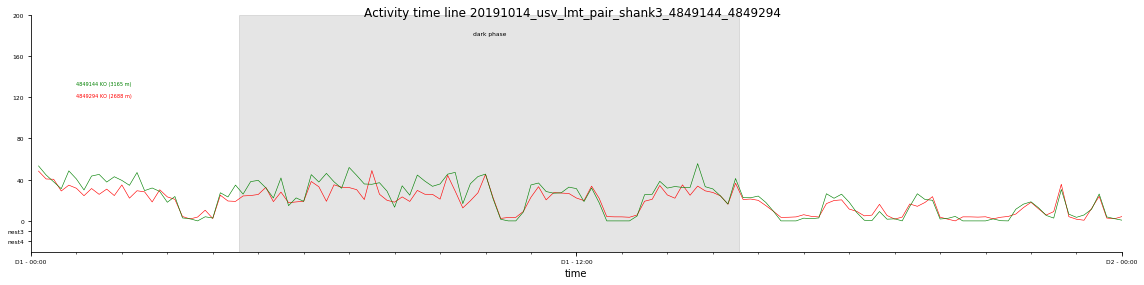

In [1]:
'''
Created on 29 Aug. 2019

@author: Elodie Ey
'''

import sys
sys.path.insert(1, "../")


import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *

import lmtanalysis
from tkinter.filedialog import askopenfilename
from tabulate import tabulate
from collections import Counter
import collections
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
from lmtanalysis.FileUtil import getFilesToProcess
from lmtanalysis.Util import convert_to_d_h_m_s, getMinTMaxTAndFileNameInput



def frameToTimeTicker(x, pos):
   
    vals= convert_to_d_h_m_s( x )
    return "D{0} - {1:02d}:{2:02d}".format( int(vals[0])+1, int(vals[1]), int(vals[2]) )
    

print("Code launched.")
saveFile = "figTimeLineActivity"
#Choose the files to process
files = getFilesToProcess()

tmin, tmax, text_file = getMinTMaxTAndFileNameInput()

for file in files:
    print(file)
    expName = os.path.basename(file)[:-7]
    print( expName )

    connection = sqlite3.connect( file )

    pool = AnimalPool( )
    pool.loadAnimals( connection )

    pool.loadDetection( start = tmin, end = tmax, lightLoad=True)

    #Load the timeline of the nest4 event over all individuals
    print( "Loading all nest4 for file " + file )
    nest4TimeLine = {}
    nest4TimeLine["all"] = EventTimeLine( connection, "Nest4", minFrame=tmin, maxFrame=tmax )

    #Load the timeline of the nest3 event over all individuals
    print( "Loading all nest3 for file " + file )
    nest3TimeLine = {}
    nest3TimeLine["all"] = EventTimeLine( connection, "Nest3", minFrame=tmin, maxFrame=tmax )

    print("loading night events for file " + file)
    nightTimeLine = EventTimeLine( connection, "night" , minFrame=tmin, maxFrame=tmax )

    ''' build the plot '''
    ymax=200
    ymin=-30
    fig, ax = plt.subplots( 1,1 , figsize=(16, 4 ) )
    ax = plt.gca() # get current axis
    ax.set_xlabel("time")
    ax.set_xlim([0, tmax])
    ax.set_ylim([ymin, ymax])

    #set x axis
    formatter = matplotlib.ticker.FuncFormatter( frameToTimeTicker )
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(labelsize=6 )
    ax.xaxis.set_major_locator(ticker.MultipleLocator( 30 * 60 * 60 * 12 ))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator( 30 * 60 * 60 ))


    #draw the rectangles for the nights
    for nightEvent in nightTimeLine.getEventList():
        ax.axvspan( nightEvent.startFrame, nightEvent.endFrame, alpha=0.1, color='black')
        ax.text( nightEvent.startFrame+(nightEvent.endFrame-nightEvent.startFrame)/2 , 0.90*ymax , "dark phase" ,fontsize=6, ha='center')

    #plot the distance traveled per timeBin min time bin
    timeBin = 10
    dt = {}
    totalDistance = {}

    for animal in pool.animalDictionnary.keys():
        print ( pool.animalDictionnary[animal].RFID )
        dt[animal] = [x/100 for x in pool.animalDictionnary[animal].getDistancePerBin(binFrameSize = timeBin*oneMinute, maxFrame = tmax )]
        totalDistance[animal] = pool.animalDictionnary[animal].getDistance(tmin=tmin, tmax=tmax)


    nTimeBins = len(dt[1])
    print(nTimeBins)

    abs = [10*oneMinute]
    for t in range(1, nTimeBins):
        x = abs[t-1] + timeBin*oneMinute
        abs.append(x)

    #print(abs)
    print(len(abs))

    text_file.write( "{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format( "file", "rfid", "genotype", "user1", "tmin", "tmax", "totalDistance" ) )

    for animal in pool.animalDictionnary.keys():
        #print(dt[animal])
        ax.plot( abs, dt[animal], color = getAnimalColor(animal), linewidth=0.6 )

        #prepare data to be written in a txt file, with tab separating columns
        line =""
        line+= str ( file )+ "\t"
        line+= str ( pool.animalDictionnary[animal].RFID )+ "\t"
        line+= str ( pool.animalDictionnary[animal].genotype )+ "\t"
        line+= str ( pool.animalDictionnary[animal].user1 )+ "\t"
        line+= str ( tmin )+ "\t"
        line+= str ( tmax )+ "\t"
        line+= str ( totalDistance[animal]/100 )+ "\t"

        for val in dt[animal]:
            line+= str( val )+ "\t"

        text_file.write( line )
        text_file.write( "\n" ) 

    text_file.close()
    
    #Print the name and genotype of the animals on the graph, with the corresponding colors and the total distance traveled over the experiment
    legendHeight = 0.6*ymax
    for animal in pool.animalDictionnary.keys():
        print ( pool.animalDictionnary[animal].RFID )
        ax.text(30*60*60, legendHeight, "{} {} ({} m)".format(pool.animalDictionnary[animal].RFID[5:], pool.animalDictionnary[animal].genotype, round(totalDistance[animal]/100)), color=getAnimalColor(animal), fontsize=5 )
        legendHeight += 12 


    yLabels=[]
    line = -20
    yTickList = []
    addThickness=0

    fig.suptitle("Activity time line {}".format( expName ))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #draw the nest4 time line
    yLabels.append("nest4")
    lineData = []

    for eventList in nest4TimeLine["all"].eventList:                                
        lineData.append( ( eventList.startFrame-addThickness , eventList.duration()+addThickness ))    

    ax.broken_barh( lineData , ( line-4, 4 ), facecolors = "black" )    
    yTickList.append(line)

    line+=10

    #draw the nest3 time line
    yLabels.append("nest3")
    addThickness=0
    lineData = []

    for eventList in nest3TimeLine["all"].eventList:                                
        lineData.append( ( eventList.startFrame-addThickness , eventList.duration()+addThickness ))    

    ax.broken_barh( lineData , ( line-4, 4 ), facecolors = "black" )    
    yTickList.append(line)

    line+=10

    #draw the y axis  
    yLab=[0, 40, 80, 120, 160, 200]
    for i in yLab:
        yTickList.append(i)    
        yLabels.append(i)

    ax.set_yticks( yTickList )
    ax.set_yticklabels( yLabels )

    plt.tight_layout()
    print ("Saving figure...")
    figureFileName = "FigActivityTimeLine_{}.pdf".format( expName )
    print( "Saving figure to ", figureFileName )
    fig.savefig( figureFileName ,dpi=100)
    plt.show()
    plt.close( fig )
    
